In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as sk_pre
import sklearn.decomposition as sk_dec
import sklearn.model_selection as sk_mos
import sklearn.neural_network as sk_nn
import sklearn.linear_model as sk_ln
import yaml
import networkx as nx
import re

from dataclasses import dataclass

In [124]:
maestro_data = pd.read_csv("../data/maestro-calculated.csv", low_memory=False)
# maestro_data = maestro_data[(maestro_data["workflow_name"] == "securitization-flow")]

In [125]:
jobs = maestro_data["job_name"].unique()
business_day = maestro_data["business-day"].unique()

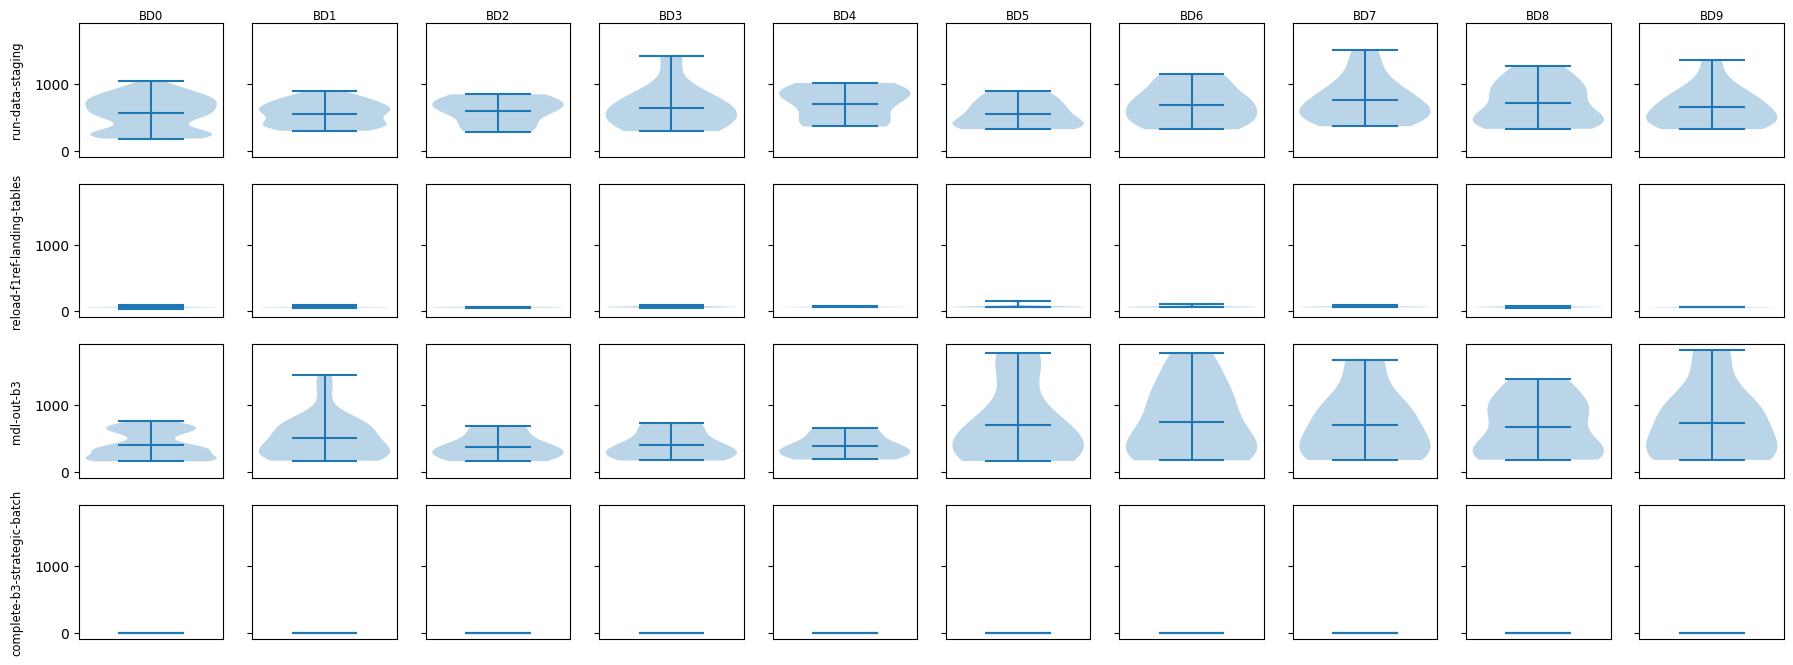

In [126]:
tasks = [6, 4, 17, 19]
COLUMN_NAME = "event-processing-time"

fig, ax = plt.subplots(len(tasks), 10, figsize=(2*len(business_day), 2*len(tasks)), sharey=True, sharex=True)
for j, task in enumerate(tasks):
    job = jobs[task]
    for i, bd in enumerate([f"BD{i}" for i in range(10)]):
        ax[j, i].xaxis.set_visible(False)
        arr = maestro_data.filter(like=COLUMN_NAME)[(maestro_data["job_name"] == job) & (maestro_data["business-day"] == bd)]
        nparr = arr.to_numpy()
        try:
            q01, q99 = np.quantile(nparr, 0.05), np.quantile(nparr, 0.95)
            ax[j, i].violinplot(arr[(q01 <= arr[COLUMN_NAME]) & (arr[COLUMN_NAME] <= q99)], range(1), showmeans=True)
        except:
            print(f"{job}, has no entries for BD == {bd}")

for ax_, row in zip(ax[:, 0], tasks):
    ax_.annotate(jobs[row], 
        xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad, 0),
        xycoords=ax_.yaxis.label, textcoords='offset points',
        size='small', ha='right', va='center',
        rotation=90.0
    )

for ax_, col in zip(ax[0, :], range(10)):
    ax_.annotate(f"BD{col}",
        xy=(0.5, 1), xytext=(0, 5),
        xycoords="axes fraction", textcoords='offset points',
        size='small', ha='center', va='center',
    )

In [134]:
@dataclass(order=False)
class Job:
    q05: float
    q95: float
    mean: float
    len: float
    score: float
    job: str

    def __str__(self):
        return f"<q05={self.q05: 9.2f} q95={self.q95: 9.2f} mean={self.mean: 9.2f} len={self.len: 4d} score={self.score: 9.2f} job={self.job}>"
    
    def __hash__(self) -> int:
        return hash(str(self))

trainable_jobs_nn = set()
trainable_jobs_lr = set()

# columns_label = {
#     "skip-mdl-out", "batch-workflow", "flow-type",
#     "rules-branch", "business-day", "batch-instance-seq", "ib-run-id",
#     "hac-run-id", "regulatory-approaches"
# }
columns_label = {
    'regulatory-approaches', 'ib-run-id', 'rules-branch',
    'processing-location-is-eur', 'event-total-time', 'skip-mdl-out', 'business_date',
    'setenv', 'bsinp-run-id', 'processing-location-is-sec',
    'processing-location-is-pac', 'rd-run-id', 'source-type-is-ib',
    'business-day', 'processing-location-is-ch', 'batch-instance-seq',
    'processing-location-is-ams', 'batch-workflow',
    'pb-run-id', 'source-type-is-pb', 'process-flag', 'flow-type',
    'hac-run-id', 'skip-mdl-landing'
}
# "event_success_time"
for job in jobs:
    labelizer = dict.fromkeys(columns_label, None)
    maestro_cut = maestro_data[list(columns_label) + ["event-processing-time"]][maestro_data["job_name"] == job].copy()
    maestro_times = maestro_cut.pop("event-processing-time").astype(float)

    q05, q95 = maestro_times.quantile(0.02), maestro_times.quantile(0.98)
    cut = maestro_times[(maestro_times >= q05) & (maestro_times <= q95)]
    mean = cut.mean()
    maestro_times /= mean
    if mean == 0:
        print(f'Skipping job: {job}, q05: {q05:.04}, q95: {q95:.04}, mean: {mean:.04}, len: {len(cut)}')
        continue

    for i, item in enumerate(list(columns_label)):
        labelizer[item] = sk_pre.LabelEncoder()
        labelizer[item].fit(list(set(maestro_cut[item])))
        maestro_cut[item] = labelizer[item].fit_transform(maestro_cut[item])

    x_train, x_test, y_train, y_test = sk_mos.train_test_split(maestro_cut, maestro_times)

    nn = sk_nn.MLPRegressor(max_iter=10_000, activation="logistic", batch_size=min(32, len(y_train)), hidden_layer_sizes=[100, 100])
    lr = sk_ln.LinearRegression()
    nn.fit(x_train, y_train)
    lr.fit(x_train, y_train)
    trainable_jobs_nn.add(Job(q05, q95, mean, len(cut), nn.score(x_test, y_test), job))
    trainable_jobs_lr.add(Job(q05, q95, mean, len(cut), lr.score(x_test, y_test), job))
    

Skipping job: b3-calc-completed, q05: 0.0, q95: 0.0, mean: 0.0, len: 401
Skipping job: complete-b3-strategic-batch, q05: 0.0, q95: 0.0, mean: 0.0, len: 400
Skipping job: skip-regional-batches, q05: 0.0, q95: 0.0, mean: 0.0, len: 148
Skipping job: complete-strategic-batch-sec, q05: 0.0, q95: 0.0, mean: 0.0, len: 151


In [135]:
for i in sorted(list(trainable_jobs_lr), key=lambda a: a.mean, reverse=True):
    print(i)

<q05=  1315.08 q95=  2665.44 mean=  2205.87 len=  23 score=     0.91 job=run-b3lvr-calculation>
<q05=   776.90 q95=  1505.02 mean=  1161.82 len=  22 score=     0.98 job=mdl-out-lvr>
<q05=   337.08 q95=  2360.00 mean=  1060.66 len= 388 score=     0.91 job=land-f1mdl-data>
<q05=   442.60 q95=  1487.60 mean=  1022.47 len= 391 score=     0.84 job=reload-harmonized-non-reference-tables>
<q05=   324.06 q95=  4080.22 mean=  1014.57 len= 386 score=     0.90 job=run-b3std-calculation>
<q05=   223.18 q95=  1882.82 mean=  1007.78 len= 392 score=     0.98 job=run-data-harmonization>
<q05=   412.00 q95=  1203.00 mean=   747.16 len= 164 score=     0.73 job=reload-securitization-tables-b3>
<q05=   259.00 q95=  2476.84 mean=   739.29 len= 387 score=     0.95 job=run-b3ler-calculation>
<q05=   408.66 q95=  1184.68 mean=   719.38 len= 176 score=     0.53 job=reload-securitization-tables-b3std>
<q05=   289.30 q95=  2064.70 mean=   696.75 len= 386 score=     0.98 job=run-b3-calculation>
<q05=   437.00 q95

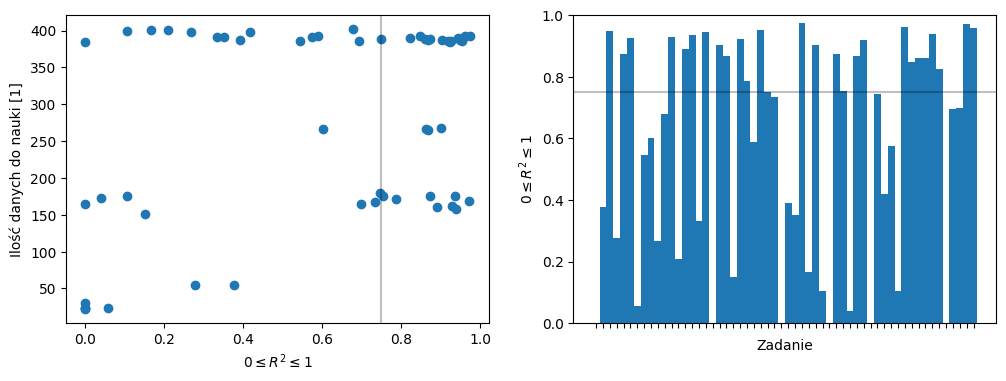

In [129]:
line = 0.75
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].bar(range(len(list(trainable_jobs_nn))), [i.score for i in list(trainable_jobs_nn)], 1)
ax[1].set_ylim(0, 1)
ax[1].set_ylabel("$0 \leq R^2 \leq 1$")
ax[1].set_xlabel("Zadanie")
ax[1].xaxis.set_ticks(range(len(list(trainable_jobs_nn))))
ax[1].xaxis.set_ticklabels("")
x_low, x_high = ax[1].get_xlim()
ax[1].set_xlim(x_low, x_high)
ax[1].hlines(line, x_low, x_high, "black", alpha=0.25)


array = np.clip(np.array([(i.score, i.len) for i in list(trainable_jobs_nn)]), 0, np.inf)
ax[0].set_xlabel("$0 \leq R^2 \leq 1$")
ax[0].set_ylabel("Ilość danych do nauki [1]")
ax[0].scatter(array[:, 0], array[:, 1])
y_low, y_high = ax[0].get_ylim()
ax[0].set_ylim(y_low, y_high)
ax[0].vlines(line, y_low, y_high, colors="black", alpha=0.25)

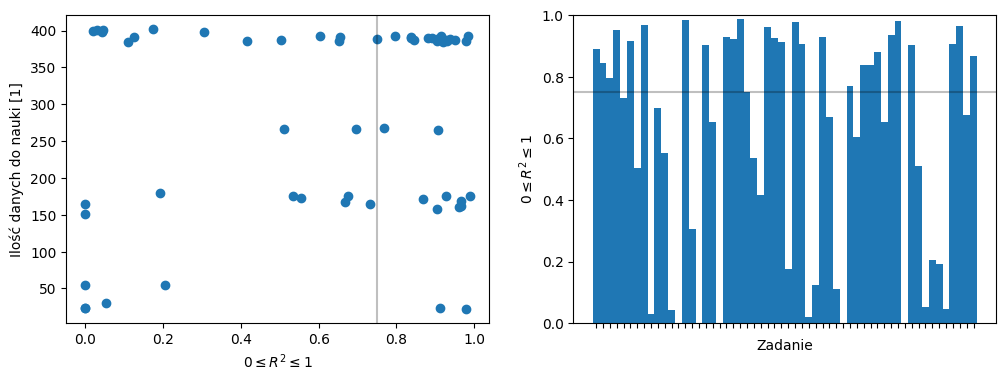

In [136]:
line = 0.75
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].bar(range(len(list(trainable_jobs_lr))), [i.score for i in list(trainable_jobs_lr)], 1)
ax[1].set_ylim(0, 1)
ax[1].set_ylabel("$0 \leq R^2 \leq 1$")
ax[1].set_xlabel("Zadanie")
ax[1].xaxis.set_ticks(range(len(list(trainable_jobs_lr))))
ax[1].xaxis.set_ticklabels("")
x_low, x_high = ax[1].get_xlim()
ax[1].set_xlim(x_low, x_high)
ax[1].hlines(line, x_low, x_high, "black", alpha=0.25)


array = np.clip(np.array([(i.score, i.len) for i in list(trainable_jobs_lr)]), 0, np.inf)
ax[0].set_xlabel("$0 \leq R^2 \leq 1$")
ax[0].set_ylabel("Ilość danych do nauki [1]")
ax[0].scatter(array[:, 0], array[:, 1])
y_low, y_high = ax[0].get_ylim()
ax[0].set_ylim(y_low, y_high)
ax[0].vlines(line, y_low, y_high, colors="black", alpha=0.25)

In [130]:
# why colon is not in quote in yaml wtf
pattern = re.compile(r"^(\s+[\w-]+: )(.*:.*)$", re.MULTILINE)

with open("../data/securitization-flow.yml") as file:
    content = ""
    for line in file:
        if(match := pattern.match(line)):
            pre, missing_quote = match.groups()
            content += f'{pre}"{missing_quote}"\n'
        else:
            content += line

    securization_flow_yaml = yaml.load(content, yaml.Loader)

In [131]:
securization_flow = nx.DiGraph()
for job_pre in securization_flow_yaml["workflows"][0]["jobs"]:
    if (job := job_pre.get("job", None)):
        name = job.get("name", None)
        for precondition in job.get("precondition", []):
            securization_flow.add_edge(job.get("name"), precondition)

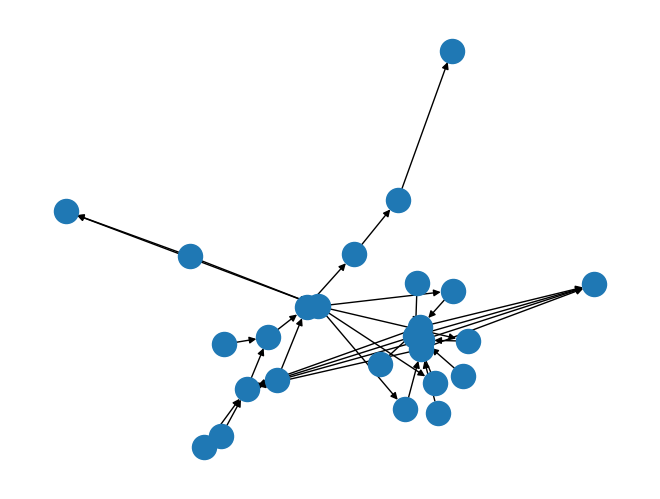

In [132]:
nx.draw(securization_flow)